<a href="https://colab.research.google.com/github/lookmeebbear/GeoAI_DOL/blob/main/GeoAI_DOL_LandcoverClassification_IntroDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction to Deep Learning for Remote Sensing**

**Start from RGB Satellite Image**

Thepchai Srinoi

Department of Survey Engineering

Chulalongkorn University

ติดตั้งเครื่องมือเดอะแบกเปิดภาพดาวเทียม rasterio ..

In [ ]:
!pip install rasterio visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 60.3 MB/s eta 0:00:00


นำเข้าเครื่องมือที่จำเป็น

In [ ]:
# processing and reading images
import zipfile
import requests
import io
from PIL import Image
from skimage.color import rgb2gray
from keras.preprocessing.image import ImageDataGenerator
import rasterio
from rasterio.plot import show, show_hist

# tensor processing
import numpy as np
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer

# plotting
import matplotlib.pyplot as plt
from keras.utils import plot_model

# modeling
import visualkeras
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
from keras.optimizers import RMSprop
from keras.applications import vgg16
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# evaluation metrics
from sklearn.metrics import classification_report
import pandas as pd

ดาวน์โหลดข้อมูลตัวอย่างของเรา eurosat ... sentinel2

In [ ]:
# https://drive.google.com/file/d/1MQx8NJCUqQGrhVI5IrPMnm3It3xI7n_z/view?usp=sharing
!gdown https://drive.google.com/uc?id=1MQx8NJCUqQGrhVI5IrPMnm3It3xI7n_z

Downloading...
From: https://drive.google.com/uc?id=1MQx8NJCUqQGrhVI5IrPMnm3It3xI7n_z
To: /content/EuroSAT_Sample.zip
100% 3.48M/3.48M [00:00<00:00, 171MB/s]


แตกไฟล์ จับใส่ array เก็บข้อมูล สอน และ ทดสอบ

In [ ]:
# myinput zipfile
data = '/content/EuroSAT_Sample.zip'
z = zipfile.ZipFile( data )

# get file names
txtfiles = []
for file in z.namelist():
  txtfiles.append(file)

# keep only those containing ".jpg"
txtfiles = [x for x in txtfiles if ".jpg" in x]

# read images to numpy array
XImages = np.zeros([len(txtfiles), 64, 64, 3])

i = 0
for pic in txtfiles:
  XImages[i] = np.asarray(Image.open(z.open(pic))).astype('uint8')/255
  i += 1

print(i)
del z

1000


In [ ]:
!unzip EuroSAT_Sample.zip

Archive:  EuroSAT_Sample.zip
   creating: EuroSAT_Sample/AnnualCrop/
  inflating: EuroSAT_Sample/AnnualCrop/AnnualCrop_1.jpg  
  inflating: EuroSAT_Sample/AnnualCrop/AnnualCrop_10.jpg  
  inflating: EuroSAT_Sample/AnnualCrop/AnnualCrop_100.jpg  
  inflating: EuroSAT_Sample/AnnualCrop/AnnualCrop_11.jpg  
  inflating: EuroSAT_Sample/AnnualCrop/AnnualCrop_12.jpg  
  inflating: EuroSAT_Sample/AnnualCrop/AnnualCrop_13.jpg  
  inflating: EuroSAT_Sample/AnnualCrop/AnnualCrop_14.jpg  
  inflating: EuroSAT_Sample/AnnualCrop/AnnualCrop_15.jpg  
  inflating: EuroSAT_Sample/AnnualCrop/AnnualCrop_16.jpg  
  inflating: EuroSAT_Sample/AnnualCrop/AnnualCrop_17.jpg  
  inflating: EuroSAT_Sample/AnnualCrop/AnnualCrop_18.jpg  
  inflating: EuroSAT_Sample/AnnualCrop/AnnualCrop_19.jpg  
  inflating: EuroSAT_Sample/AnnualCrop/AnnualCrop_2.jpg  
  inflating: EuroSAT_Sample/AnnualCrop/AnnualCrop_20.jpg  
  inflating: EuroSAT_Sample/AnnualCrop/AnnualCrop_21.jpg  
  inflating: EuroSAT_Sample/AnnualCrop/AnnualCr

In [ ]:
# Get labels in numpy array as strings
labs = np.empty(len(txtfiles), dtype = 'S20')

i = 0
for label in txtfiles:
  labs[i] = (label.split('/')[1]).split('_')[0]
  i += 1

labs[ [j for j in range(0,1000,100)] ]

array([b'AnnualCrop', b'Forest', b'HerbaceousVegetation', b'Highway',
       b'Industrial', b'Pasture', b'PermanentCrop', b'Residential',
       b'River', b'Sealake'], dtype='|S20')

In [ ]:
# change them to integers in alphabetical order
label_names, yLabels = np.unique(labs, return_inverse=True)

label_Dict = dict(zip(np.unique(yLabels), label_names))
print(label_Dict)
np.array(np.unique(yLabels, return_counts=True)).T

{0: b'AnnualCrop', 1: b'Forest', 2: b'HerbaceousVegetation', 3: b'Highway', 4: b'Industrial', 5: b'Pasture', 6: b'PermanentCrop', 7: b'Residential', 8: b'River', 9: b'Sealake'}


array([[  0, 100],
       [  1, 100],
       [  2, 100],
       [  3, 100],
       [  4, 100],
       [  5, 100],
       [  6, 100],
       [  7, 100],
       [  8, 100],
       [  9, 100]])

แสดงภาพตัวอย่าง

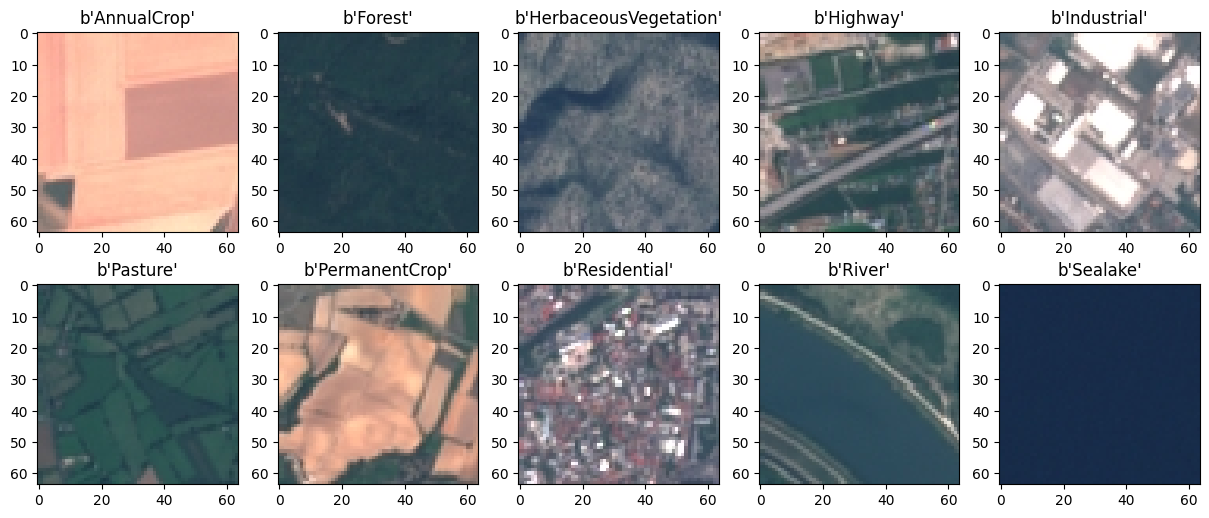

In [ ]:
import random
tmp = random.randint(0, 99)

plt.figure(figsize=(15,6))

# test that the labels and images read in properly
j = 0
for r in range(2) :
  for c in range(5) :
    ax = plt.subplot2grid((2,5), (r,c))
    num = 250+j
    tmp_update = tmp + 100*j
    img = XImages[tmp_update]
    ax.set_title( label_names[yLabels[tmp_update]] )
    ax.imshow(img)
    j += 1

แบ่งข้อมูลสอน และ ทดสอบแบบจำลอง

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(XImages, yLabels,
                                                    stratify = yLabels,
                                                    train_size = 0.5,
                                                    random_state=42)

แปลง class output เป็นรูปแบบที่เหมาะสม

In [ ]:
# number of classes
num_classes = len(np.array(np.unique(yLabels)))

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# class 8 => array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

สร้างสรรค์ architecture network ในฝันกันเถอะ

In [ ]:
input_shape = X_train.shape[1:]
print(input_shape)

batch_size = 64
epochs = 100

(64, 64, 3)


ชุดแรก เวกเตอร์เดี่ยวเสืยวทั้งบาง

In [ ]:
# Initialize grayscale arrays
X_train_BW = np.zeros([X_train.shape[0],
                       X_train.shape[1],
                       X_train.shape[2]])

X_test_BW = np.zeros([X_test.shape[0],
                      X_test.shape[1],
                      X_test.shape[2]])

# convert RGB arrays to grayscale
for i in range(X_train.shape[0]):
  X_train_BW[i] = rgb2gray(X_train[i])
  X_test_BW[i] = rgb2gray(X_test[i])

# flatten grayscale arrays
X_train_BW = X_train_BW.reshape(X_train_BW.shape[0],
                                X_train_BW.shape[1] * X_train_BW.shape[2])

X_test_BW = X_test_BW.reshape(X_test_BW.shape[0],
                              X_test_BW.shape[1] * X_test_BW.shape[2])

print("X_train_BW shape:" + str(X_train_BW.shape))
print("X_test_BW shape:" + str(X_test_BW.shape))
print("y_train shape:" + str(y_train.shape))
print("y_test shape:" + str(y_test.shape))

X_train_BW shape:(500, 4096)
X_test_BW shape:(500, 4096)
y_train shape:(500, 10)
y_test shape:(500, 10)


กรณีแรก โยนเข้า Dense ที่มีจำนวนเท่ากับคลาส จับแยกกลุ่มเลย รีบมาก

In [ ]:
# save model to here
model_file = '/content/M1.h5'

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [checkpoint]

M1 = Sequential()
M1.add(Dense(num_classes, activation='softmax', input_shape=(4096,)))

visualkeras.layered_view(M1, legend=True )

M1.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

batch_size = 64
epochs = 100

history_M1 = M1.fit(X_train_BW, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = callback_list,
                    validation_data=(X_test_BW, y_test))

Epoch 1/100
8/8 [==============================] - 3s 41ms/step - loss: 3.6927 - accuracy: 0.0940 - val_loss: 2.9520 - val_accuracy: 0.1000
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 2.6597 - accuracy: 0.0680 - val_loss: 2.7635 - val_accuracy: 0.0960
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 2.6169 - accuracy: 0.0800 - val_loss: 2.6588 - val_accuracy: 0.1340
Epoch 4/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 10ms/step - loss: 2.6806 - accuracy: 0.1140 - val_loss: 2.6932 - val_accuracy: 0.1000
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 2.5632 - accuracy: 0.1100 - val_loss: 2.7347 - val_accuracy: 0.1000
Epoch 6/100
8/8 [==============================] - 0s 13ms/step - loss: 2.5346 - accuracy: 0.1200 - val_loss: 2.5898 - val_accuracy: 0.1040
Epoch 7/100
8/8 [==============================] - 0s 10ms/step - loss: 2.5213 - accuracy: 0.1200 - val_loss: 2.8470 - val_accuracy: 0.1000
Epoch 8/100
8/8 [==============================] - 0s 11ms/step - loss: 2.5674 - accuracy: 0.1400 - val_loss: 2.4902 - val_accuracy: 0.1160
Epoch 9/100
8/8 [==============================] - 0s 16ms/step - loss: 2.4617 - accuracy: 0.1240 - val_loss: 2.5138 - val_accuracy: 0.1420
Epoch 10/100
8/8 [==============================] - 0s 11ms/step - loss: 2.5200 - accuracy: 0.1500 - val_loss: 2.3004 - val_accuracy: 0.1360
Epoch 11/100
8/8 [=============

In [ ]:
def plot_hist( hist ):
  history = hist
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

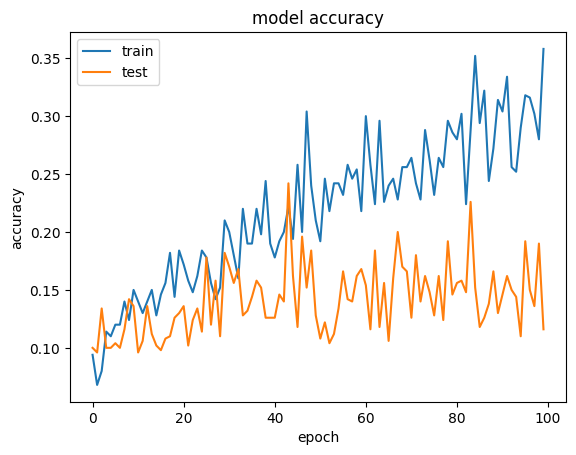

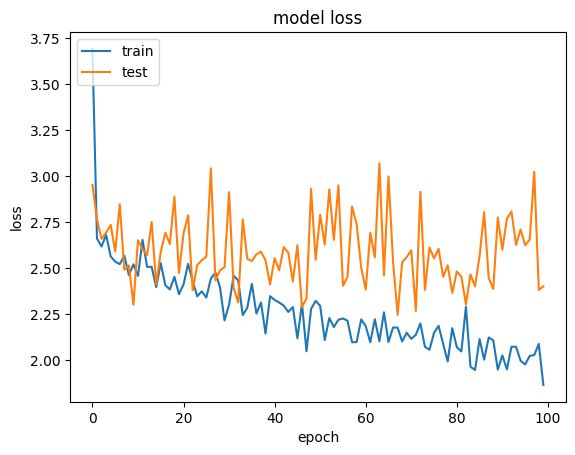

In [ ]:
plot_hist( history_M1 )

กรณีสอง โยนเข้า Deep Neural Network หนักๆ ก่อนแล้วค่อยเอาเข้า ระบบแบบแรก เผื่อจะดีขึ้น

In [ ]:
# save model to here
model_file = '/content/M2.h5'

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [checkpoint]

M2 = Sequential()
M2.add(Dense(256, activation='relu', input_shape=(4096,)))
M2.add(Dense(num_classes, activation='softmax'))

visualkeras.layered_view(M2, legend=True )

M2.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

batch_size = 64
epochs = 100

history_M2 = M2.fit(X_train_BW, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = callback_list,
                    validation_data=(X_test_BW, y_test))

Epoch 1/100
8/8 [==============================] - 1s 39ms/step - loss: 5.7890 - accuracy: 0.1000 - val_loss: 3.1828 - val_accuracy: 0.1000
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 2.8148 - accuracy: 0.0740 - val_loss: 2.6547 - val_accuracy: 0.1000
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 2.5759 - accuracy: 0.0960 - val_loss: 2.5402 - val_accuracy: 0.1000
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 2.5937 - accuracy: 0.0940 - val_loss: 2.5951 - val_accuracy: 0.1040
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 2.3798 - accuracy: 0.1080 - val_loss: 2.5779 - val_accuracy: 0.1000
Epoch 6/100
8/8 [==============================] - 0s 13ms/step - loss: 2.6658 - accuracy: 0.0780 - val_loss: 2.3088 - val_accuracy: 0.1440
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 2.4719 - accuracy: 0.1180 - val_loss: 2.3972 - val_accuracy: 0.1260
Epoch 8/100
8/8 [===

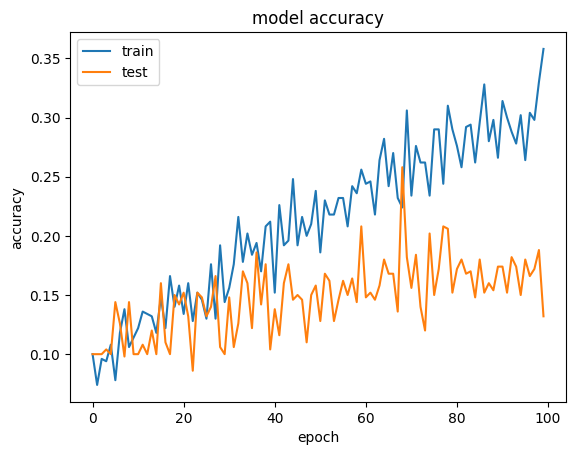

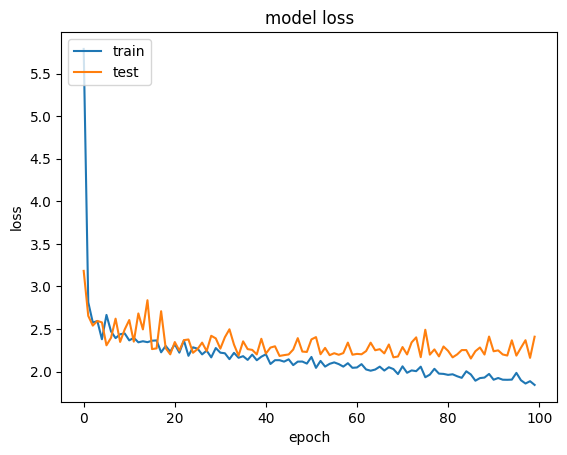

In [ ]:
plot_hist( history_M2 )

ชุดสอง เอาทั้งภาพเข้าได้แล้ว ... welcome to convolution neural network

กรณีแรก จัด Conv Layer ชุดเดียวพอ

In [ ]:
input_shape = X_train.shape[1:]

model_file = '/content/M3.h5'

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [checkpoint]

M3 = Sequential()

# Convolution Neural Network
M3.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
M3.add(Conv2D(64, (3, 3), activation='relu'))
M3.add(MaxPooling2D(pool_size=(2, 2)))
M3.add(Dropout(0.2))

# Fully Connected Layer
M3.add(Flatten())
M3.add(Dense(256, activation='relu'))
M3.add(Dropout(0.2))
M3.add(Dense(num_classes, activation='softmax'))

visualkeras.layered_view(M3, legend=True )

M3.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history_M3 = M3.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                 callbacks = callback_list,
                    verbose=1,
                    validation_data=(X_test, y_test))

Epoch 1/100
8/8 [==============================] - 6s 187ms/step - loss: 3.9862 - accuracy: 0.1160 - val_loss: 2.1743 - val_accuracy: 0.2160
Epoch 2/100
8/8 [==============================] - 1s 81ms/step - loss: 2.1816 - accuracy: 0.2080 - val_loss: 2.1483 - val_accuracy: 0.1960
Epoch 3/100
8/8 [==============================] - 1s 90ms/step - loss: 2.0560 - accuracy: 0.2220 - val_loss: 1.8517 - val_accuracy: 0.3520
Epoch 4/100
8/8 [==============================] - 1s 89ms/step - loss: 1.9194 - accuracy: 0.2820 - val_loss: 1.8009 - val_accuracy: 0.3560
Epoch 5/100
8/8 [==============================] - 5s 639ms/step - loss: 1.9344 - accuracy: 0.2800 - val_loss: 1.7542 - val_accuracy: 0.3380
Epoch 6/100
8/8 [==============================] - 0s 44ms/step - loss: 1.7073 - accuracy: 0.3560 - val_loss: 1.8057 - val_accuracy: 0.2560
Epoch 7/100
8/8 [==============================] - 0s 34ms/step - loss: 1.7111 - accuracy: 0.3220 - val_loss: 1.7551 - val_accuracy: 0.3260
Epoch 8/100
8/8 [=

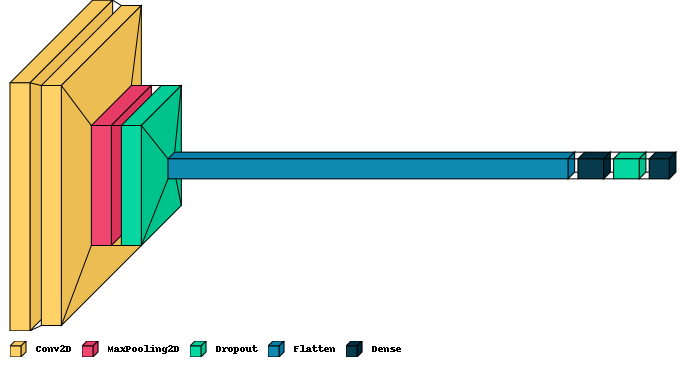

In [ ]:
visualkeras.layered_view(M3, legend=True )

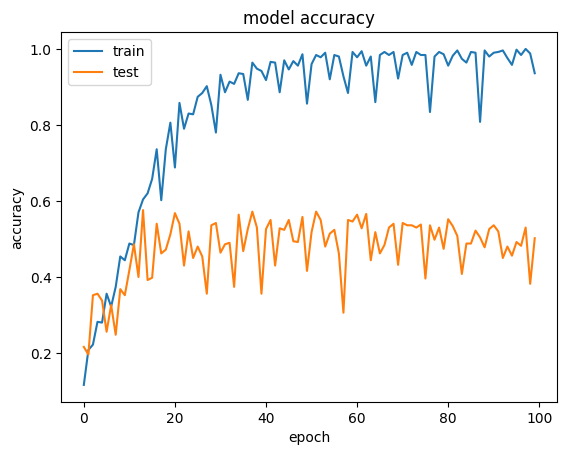

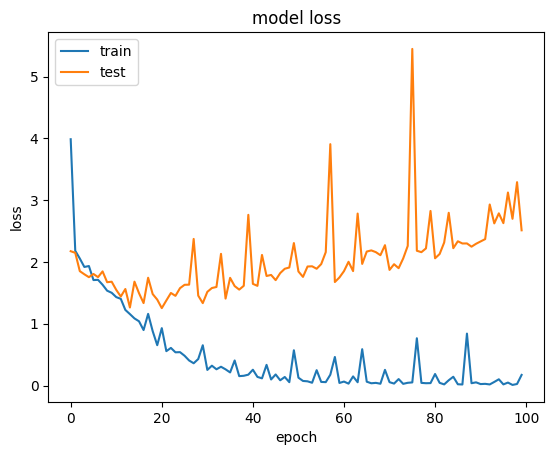

In [ ]:
plot_hist( history_M3 )

กรณีสอง จัด Conv Layer หลายๆชุด เผื่อจะดีขึ้น

In [ ]:
input_shape = X_train.shape[1:]

model_file = '/content/M4.h5'

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [checkpoint]

M4 = Sequential()

# Convolution Neural Network
M4.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
M4.add(MaxPooling2D(pool_size=(2, 2)))

M4.add(Conv2D(64, (3, 3), activation='relu'))
M4.add(MaxPooling2D(pool_size=(2, 2)))

M4.add(Conv2D(128, (3, 3), activation='relu'))
M4.add(MaxPooling2D(pool_size=(2, 2)))

M4.add(Conv2D(256, (3, 3), activation='relu'))
M4.add(MaxPooling2D(pool_size=(2, 2)))

# Fully Connected Layer
M4.add(Flatten())
M4.add(Dropout(0.5))
M4.add(Dense(512, activation='relu'))
M4.add(Dense(num_classes, activation='softmax'))

visualkeras.layered_view(M4, legend=True )


M4.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history_M4 = M4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks = callback_list,
                    verbose=1,
                    validation_data=(X_test, y_test))

<PIL.Image.Image image mode=RGBA size=622x367 at 0x7AE1FC035750>
Epoch 1/100
8/8 [==============================] - 4s 116ms/step - loss: 2.2997 - accuracy: 0.0920 - val_loss: 2.2798 - val_accuracy: 0.1460
Epoch 2/100
7/8 [=========================>....] - ETA: 0s - loss: 2.2210 - accuracy: 0.1362

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 23ms/step - loss: 2.2234 - accuracy: 0.1480 - val_loss: 2.1767 - val_accuracy: 0.2140
Epoch 3/100
8/8 [==============================] - 0s 23ms/step - loss: 2.1493 - accuracy: 0.2100 - val_loss: 2.0376 - val_accuracy: 0.2120
Epoch 4/100
8/8 [==============================] - 0s 21ms/step - loss: 2.1069 - accuracy: 0.2080 - val_loss: 2.2455 - val_accuracy: 0.1000
Epoch 5/100
8/8 [==============================] - 0s 22ms/step - loss: 1.9720 - accuracy: 0.2160 - val_loss: 1.9408 - val_accuracy: 0.2080
Epoch 6/100
8/8 [==============================] - 0s 18ms/step - loss: 1.9688 - accuracy: 0.2220 - val_loss: 2.0214 - val_accuracy: 0.2120
Epoch 7/100
8/8 [==============================] - 0s 26ms/step - loss: 1.8800 - accuracy: 0.2460 - val_loss: 1.7372 - val_accuracy: 0.2700
Epoch 8/100
8/8 [==============================] - 0s 18ms/step - loss: 1.8799 - accuracy: 0.2580 - val_loss: 1.9835 - val_accuracy: 0.2260
Epoch 9/100
8/8 [===============

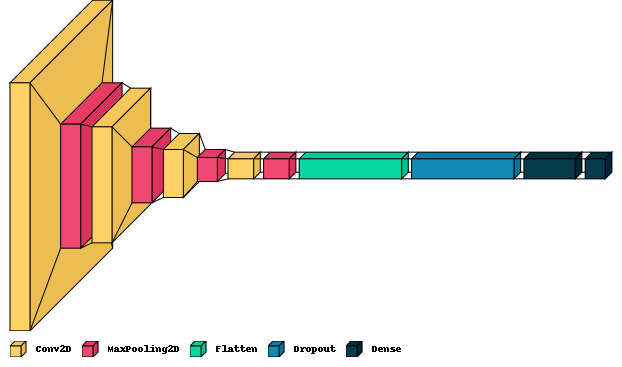

In [ ]:
visualkeras.layered_view(M4, legend=True )

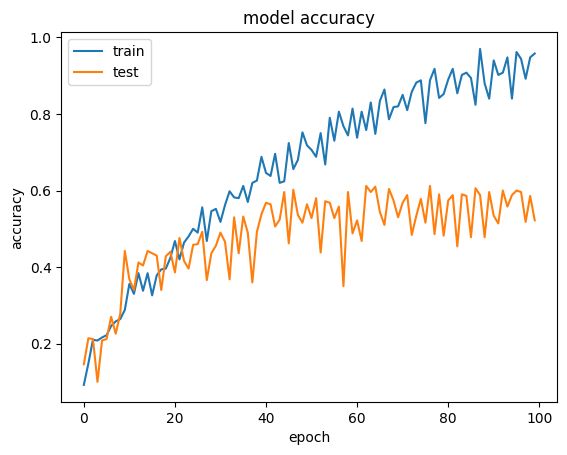

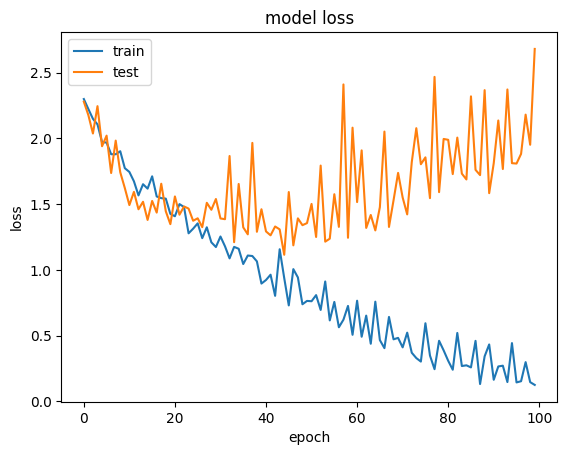

In [ ]:
plot_hist( history_M4 )

ชุดสาม ไปใช้โมเดลชาวบ้านเป็น convolutional base ทำ transfer learning

58889256/58889256 [==============================] - 1s 0us/step


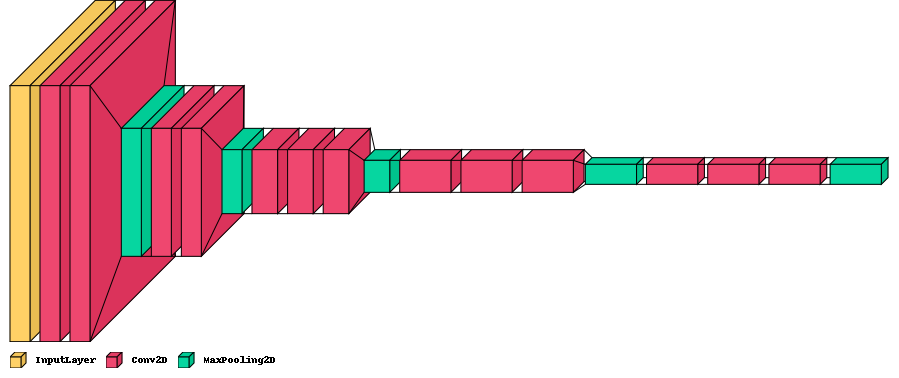

In [ ]:
conv_base = vgg16.VGG16(include_top=False,
            input_shape = input_shape)

visualkeras.layered_view(conv_base, legend=True )

In [ ]:
# how many weights are trainable in the VGG16 model?
len(conv_base.trainable_weights)

26

กรณีแรก จับแช่แข็ง แล้วเอา fully connected layer ประกบ แม่ง

In [ ]:
# freeze the weights
for layer in conv_base.layers:
  layer.trainable = False
len(conv_base.trainable_weights)

0

In [ ]:
input_shape = X_train.shape[1:]

model_file = '/content/M5.h5'

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [checkpoint]

M5 = Sequential()

# Convolution Neural Network
M5.add( conv_base )

# Fully Connected Layer
M5.add(Flatten())
M5.add(Dropout(0.5))
M5.add(Dense(512, activation='relu'))
M5.add(Dense(num_classes, activation='softmax'))

visualkeras.layered_view(M5, legend=True )

M5.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history_M5 = M5.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks = callback_list,
                    verbose=1,
                    validation_data=(X_test, y_test))

Epoch 1/100
8/8 [==============================] - 5s 320ms/step - loss: 2.2672 - accuracy: 0.2820 - val_loss: 1.4908 - val_accuracy: 0.4340
Epoch 2/100
1/8 [==>...........................] - ETA: 0s - loss: 1.5122 - accuracy: 0.5000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 1s 69ms/step - loss: 1.3488 - accuracy: 0.4960 - val_loss: 1.5304 - val_accuracy: 0.4040
Epoch 3/100
8/8 [==============================] - 1s 94ms/step - loss: 1.1386 - accuracy: 0.5880 - val_loss: 1.0718 - val_accuracy: 0.5700
Epoch 4/100
8/8 [==============================] - 1s 78ms/step - loss: 1.0078 - accuracy: 0.6240 - val_loss: 0.9469 - val_accuracy: 0.6860
Epoch 5/100
8/8 [==============================] - 1s 72ms/step - loss: 0.9676 - accuracy: 0.6320 - val_loss: 1.0489 - val_accuracy: 0.5900
Epoch 6/100
8/8 [==============================] - 0s 54ms/step - loss: 0.7791 - accuracy: 0.7220 - val_loss: 1.1687 - val_accuracy: 0.5940
Epoch 7/100
8/8 [==============================] - 0s 52ms/step - loss: 0.7583 - accuracy: 0.7480 - val_loss: 1.0301 - val_accuracy: 0.6100
Epoch 8/100
8/8 [==============================] - 1s 79ms/step - loss: 0.8082 - accuracy: 0.7060 - val_loss: 0.9374 - val_accuracy: 0.6720
Epoch 9/100
8/8 [===============

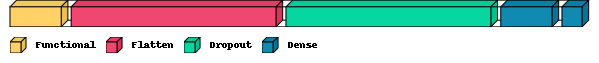

In [ ]:
visualkeras.layered_view(M5, legend=True )

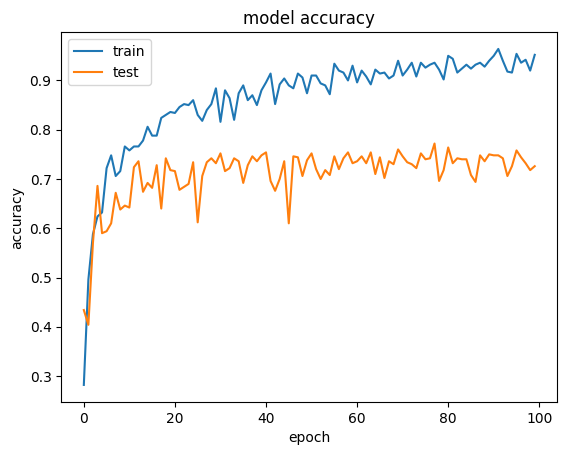

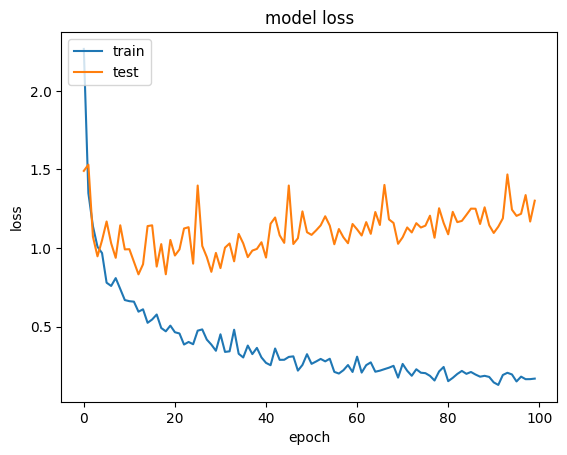

In [ ]:
plot_hist( history_M5 )

กรณีสอง ละลายน้ำแข็ง vgg16 บางชั้น solo learning กันต่อ

In [ ]:
# unfreeze the latter 2/3ds of the base
for layer in conv_base.layers[7:]:
  layer.trainable = True
len(conv_base.trainable_weights)

18

In [ ]:
model_file = '/content/M6.h5'

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [checkpoint]

M6 = Sequential()

# Convolution Neural Network
M6.add( conv_base )

# Fully Connected Layer
M6.add(Flatten())
M6.add(Dropout(0.5))
M6.add(Dense(512, activation='relu'))
M6.add(Dense(num_classes, activation='softmax'))

# set a lower learning rate to minimize magnitude of changes to weights
M6.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr = 1e-4),
              metrics=['accuracy'])

history_M6 = M6.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test))

Epoch 1/100
8/8 [==============================] - 5s 145ms/step - loss: 2.3030 - accuracy: 0.0880 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/100
8/8 [==============================] - 1s 78ms/step - loss: 2.3028 - accuracy: 0.0840 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/100
8/8 [==============================] - 1s 79ms/step - loss: 2.3028 - accuracy: 0.0800 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/100
8/8 [==============================] - 1s 79ms/step - loss: 2.3027 - accuracy: 0.1000 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/100
8/8 [==============================] - 1s 80ms/step - loss: 2.3027 - accuracy: 0.0800 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/100
8/8 [==============================] - 1s 79ms/step - loss: 2.3028 - accuracy: 0.0940 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/100
8/8 [==============================] - 1s 98ms/step - loss: 2.3028 - accuracy: 0.0740 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 8/100
8/8 [==

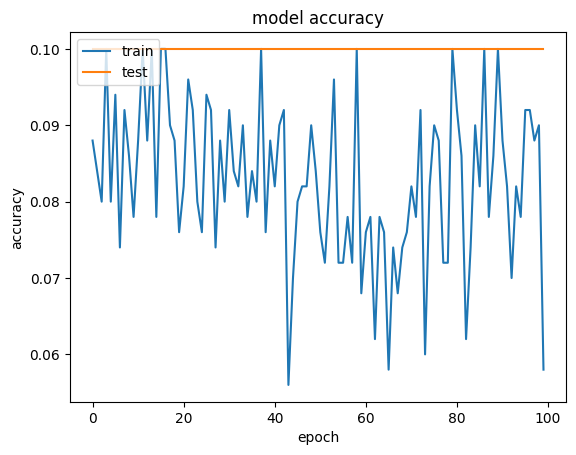

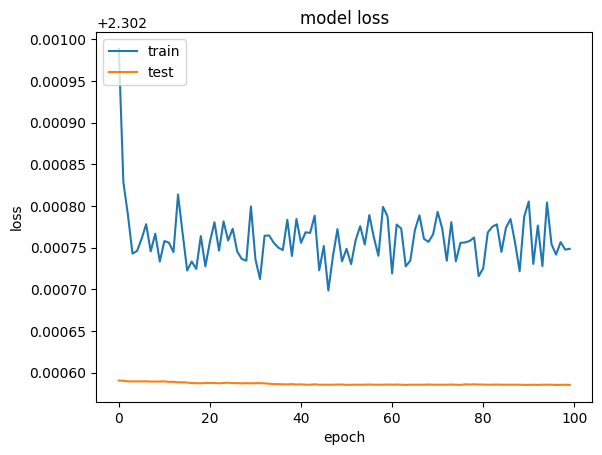

In [ ]:
plot_hist( history_M6 )

ยอมแพ้

เพิ่มอีกนิด ทดลองทำ data augmentation ... การทดลองใส่ตัวช่วยปรับค่า learning rate, reducedonPlateau สั่งหยุดเมื่อไม่มีอะไรดีขึ้น

In [ ]:
train_datagen = ImageDataGenerator(
    # rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=180,
    horizontal_flip=True,
    vertical_flip=True)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size = batch_size,
    seed = 42
)

test_generator = test_datagen.flow(
    X_test,
    y_test,
    batch_size = batch_size,
    seed = 42
)

In [ ]:
conv_base_again = vgg16.VGG16(include_top=False,
            input_shape = input_shape)

In [ ]:
# freeze the weights
for layer in conv_base_again.layers:
  layer.trainable = False
len(conv_base_again.trainable_weights)

0

In [ ]:
model_file = 'M8.h5'

early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', # what is the metric to measure
                              patience = 15, # how many epochs to continue running the model after seeing an increase in val_loss
                              restore_best_weights = True) # update the model with the best-seen weights?

reduce_LR = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                              factor = 0.1,
                                              patience = 5) # to make sure early_stop is what stops the model

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [reduce_LR, early_stop, checkpoint]

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

optimizer = RMSprop(lr = 1e-4)
lr_metric = get_lr_metric(optimizer)

# create model
M8 = Sequential()

# CNN Layer
M8.add( conv_base_again )

# Fully Connected Layer
M8.add(Flatten())
M8.add(Dropout(0.3))
M8.add(Dense(256, activation='relu'))
M8.add(Dense(num_classes, activation='softmax'))

visualkeras.layered_view(M8, legend=True )
M8.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', lr_metric])

history = M8.fit_generator(train_generator,
                 steps_per_epoch = len(X_train) // batch_size,
                 epochs = 100,
                 validation_data = test_generator,
                 validation_steps = len(X_test) // batch_size,
                 callbacks = callback_list)

<ipython-input-59-1c5c1b615d3b>:42: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = M8.fit_generator(train_generator,


Epoch 1/100
7/7 [==============================] - 2s 209ms/step - loss: 2.0477 - accuracy: 0.2844 - lr: 0.0010 - val_loss: 1.4185 - val_accuracy: 0.5156 - val_lr: 0.0010
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 142ms/step - loss: 1.3589 - accuracy: 0.5367 - lr: 0.0010 - val_loss: 1.3235 - val_accuracy: 0.4777 - val_lr: 0.0010
Epoch 3/100
7/7 [==============================] - 1s 153ms/step - loss: 1.3217 - accuracy: 0.4817 - lr: 0.0010 - val_loss: 1.1508 - val_accuracy: 0.5759 - val_lr: 0.0010
Epoch 4/100
7/7 [==============================] - 1s 111ms/step - loss: 1.1762 - accuracy: 0.5436 - lr: 0.0010 - val_loss: 1.2238 - val_accuracy: 0.5558 - val_lr: 0.0010
Epoch 5/100
7/7 [==============================] - 1s 163ms/step - loss: 1.0992 - accuracy: 0.5803 - lr: 0.0010 - val_loss: 1.0492 - val_accuracy: 0.5871 - val_lr: 0.0010
Epoch 6/100
7/7 [==============================] - 1s 147ms/step - loss: 1.0250 - accuracy: 0.6183 - lr: 0.0010 - val_loss: 0.9729 - val_accuracy: 0.7009 - val_lr: 0.0010
Epoch 7/100
7/7 [==============================] - 1s 145ms/step - loss: 1.0091 - accuracy: 0.6032 - lr: 0.0010 - val_loss: 0.9295 - val_accuracy: 0.6562 - v

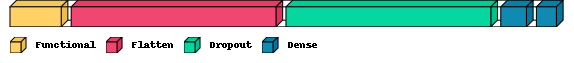

In [ ]:
visualkeras.layered_view(M8, legend=True )

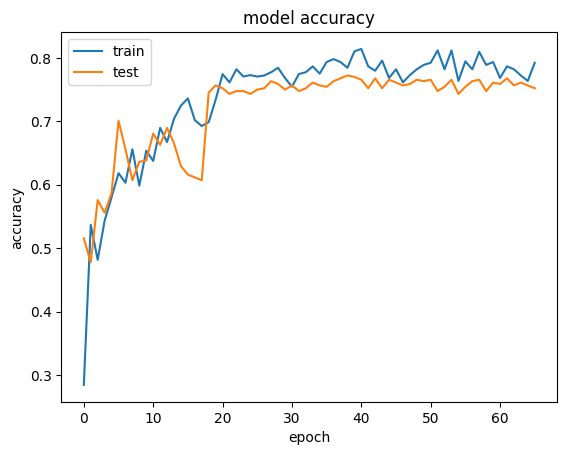

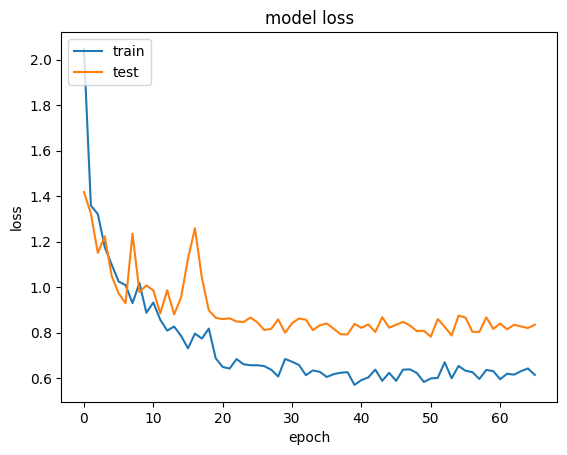

In [ ]:
plot_hist( history )

In [ ]:
score = M8.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.8280077576637268
Test accuracy: 0.7580000162124634


แสดงผลลัผธ์การตรวจสอบความถูกต้อง

In [ ]:
# Define functions for evaluating model accuracy by class and overall

def eval_model_by_class(model, test_set):

  y_test_pred_tmp = model.predict(test_set)
  y_test_pred_tmp = np.argmax(y_test_pred_tmp,axis=1)

  y_test_true = [label_Dict[x] for x in y_test_true_tmp]
  y_test_pred = [label_Dict[x] for x in y_test_pred_tmp]

  pred_df = pd.DataFrame({'y_true': y_test_true, 'y_pred': y_test_pred})
  pred_df['accurate_preds'] = pred_df.y_true == pred_df.y_pred
  pred_df = pred_df.groupby(['y_true']).sum().reset_index()
  pred_df['label_count'] = label_count
  pred_df['class_acc'] = pred_df.accurate_preds / pred_df.label_count
  pred_df = pred_df.sort_values(by = 'class_acc').reset_index()
  pred_df['overall_acc'] = sum(pred_df.accurate_preds) / sum(pred_df.label_count)
  pred_df = pred_df.sort_values('y_true').reset_index(drop = True)

  return(pred_df)

In [ ]:
y_test_true_tmp = np.argmax(y_test, axis = 1)
label_count = np.unique(y_test_true_tmp, return_counts = True)[1]

In [ ]:
M8_pred_df = eval_model_by_class(M8, X_test)
M8_pred_df

16/16 [==============================] - 1s 19ms/step


<ipython-input-63-22fc06104ae3>:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pred_df = pred_df.groupby(['y_true']).sum().reset_index()


,index,y_true,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',40,50,0.80,0.758
1,1,b'Forest',44,50,0.88,0.758
2,2,b'HerbaceousVegetation',36,50,0.72,0.758
3,3,b'Highway',25,50,0.50,0.758
4,4,b'Industrial',47,50,0.94,0.758
5,5,b'Pasture',35,50,0.70,0.758
6,6,b'PermanentCrop',34,50,0.68,0.758
7,7,b'Residential',43,50,0.86,0.758
8,8,b'River',28,50,0.56,0.758
9,9,b'Sealake',47,50,0.94,0.758


จบ สวัสดี ไม่ไหวแล้ววววว

https://youtube.com/shorts/KUM2p2Weicg?si=1cE0RIR-TBmKqMP4